#IMDB MODEL TRAINING - CUSTOM LSTM

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random2 as rn

from scipy import stats
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [45]:
df_imdb = pd.read_csv('/home/Projs/nlp-training/data/nlp-bronze/imdb/sample.csv')
df_imdb.head()

,Unnamed: 0,rating,review_detail,word_count,sentiment
0,0,4,seeing tarantinos kill bill vol 1 got watch vo...,147,1
1,2,5,critics prove morons movie definitely best ive...,297,1
2,3,2,film done many times already guys confess true...,129,0
3,4,5,chris farley one favorite comedians forever mi...,119,1
4,5,5,love anime series complaint lasted one seasont...,247,1


In [46]:
sample_size = 18000  # Desired sample size of each category

# Sample 18k instances of each category
df_imdb = pd.concat([
    df_imdb[df_imdb['sentiment'] == 0].sample(n=sample_size, random_state=42),
    df_imdb[df_imdb['sentiment'] == 1].sample(n=sample_size, random_state=42)
])

df_imdb.head()

,Unnamed: 0,rating,review_detail,word_count,sentiment
54629,62379,2,yeah spoilers cominglook movie actually buying...,239,0
7001,7872,1,remember getting cheap santo gold medallions i...,149,0
4110,4580,1,much potential movie sucked saw checked rating...,172,0
73817,84151,1,saw 12 film finally ill stand complete disagre...,880,0
35071,40003,1,well 1000 years future finally breached travel...,149,0


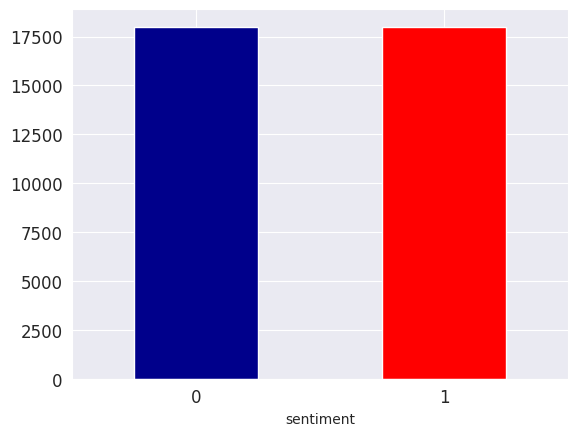

In [47]:
with sns.axes_style("darkgrid"):
    df_imdb['sentiment'].value_counts().plot.bar(color=['darkblue', 'r'], rot=0, fontsize='large')
    plt.show()

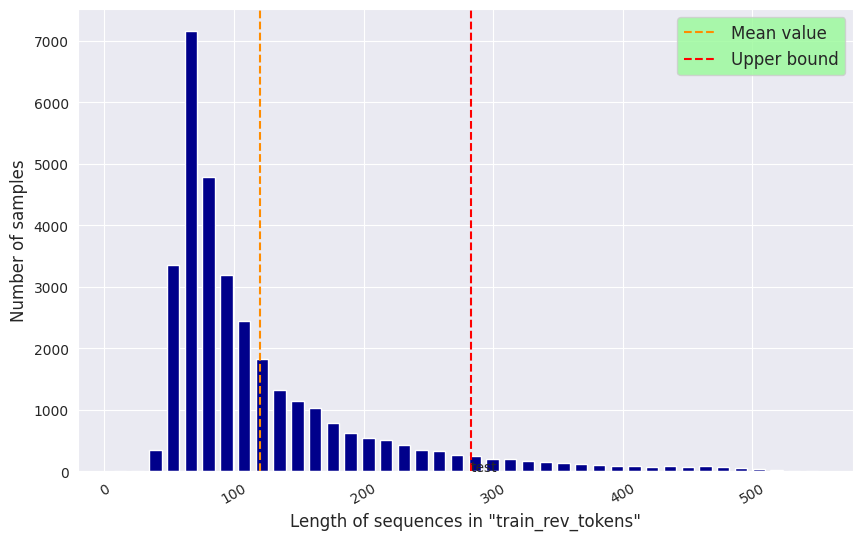

In [48]:
train_rev, test_rev, train_sent, test_sent = train_test_split(df_imdb['review_detail'], df_imdb['sentiment'], test_size=0.1, random_state=42)

dict_size = 35000
tokenizer = Tokenizer(num_words=dict_size)
tokenizer.fit_on_texts(df_imdb['review_detail'])

train_rev_tokens = tokenizer.texts_to_sequences(train_rev)
test_rev_tokens = tokenizer.texts_to_sequences(test_rev)
seq_lengths =  np.array([len(sequence) for sequence in train_rev_tokens])

upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
percentage = stats.percentileofscore(seq_lengths, upper_bound)

with sns.axes_style("darkgrid"):
    _, hist = plt.subplots(figsize=(10,6))
    hist.hist(seq_lengths[seq_lengths < 2*upper_bound], color='darkblue', bins=40, rwidth=0.7)
    hist.axvline(np.mean(seq_lengths), color='darkorange', linestyle='--', label='Mean value')
    hist.axvline(upper_bound, color='r', linestyle='--', label='Upper bound')

    plt.xlabel('Length of sequences in "train_rev_tokens"', size='large')
    plt.ylabel('Number of samples', size='large')
    plt.text(upper_bound, 0, 'test')
    plt.legend(fontsize='large', facecolor='palegreen')
    plt.xticks(rotation=30)
    plt.show()

In [49]:
train_rev_pad = pad_sequences(train_rev_tokens, maxlen=upper_bound)
test_rev_pad = pad_sequences(test_rev_tokens, maxlen=upper_bound)

idx_pad = rn.randint(0, len(train_rev_pad)-1)

output_dim = 14
units_lstm = 16
r = 0.8

model = Sequential()
model.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model.add(LSTM(units_lstm))
model.add(Dropout(r))
model.add(Dense(1, activation='sigmoid'))

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 283, 14)           490000    
                                                                 
 lstm_1 (LSTM)               (None, 16)                1984      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 492001 (1.88 MB)
Trainable params: 492001 (1.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
model.compile(optimizer='adam', loss='bce', metrics='accuracy')

In [52]:
validation_split = 0.1
batch_size = 384
epochs = 3

fitted = model.fit(train_rev_pad, train_sent, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/5
76/76 [==============================] - 13s 147ms/step - loss: 0.6757 - accuracy: 0.5822 - val_loss: 0.5616 - val_accuracy: 0.7827
Epoch 2/5
76/76 [==============================] - 10s 136ms/step - loss: 0.5059 - accuracy: 0.8029 - val_loss: 0.4023 - val_accuracy: 0.8500
Epoch 3/5
76/76 [==============================] - 11s 141ms/step - loss: 0.3579 - accuracy: 0.8745 - val_loss: 0.3174 - val_accuracy: 0.8707
Epoch 4/5
76/76 [==============================] - 11s 142ms/step - loss: 0.2758 - accuracy: 0.9171 - val_loss: 0.3129 - val_accuracy: 0.8759
Epoch 5/5
76/76 [==============================] - 11s 148ms/step - loss: 0.2203 - accuracy: 0.9397 - val_loss: 0.3156 - val_accuracy: 0.8722
